# S2 What makes a neuron spike?
## - Generation of Action Potentials

##### Developed in the Neural Engineering Laboratory at the University of Missouri by Ziao Chen. Notes added by Matt Stroud and Greg Glickert

This notebook displays an interactive plot of a spiking neuron. If you would like to learn more of the fundamentals of action potentials, scroll to the bottom of this notebook to view a video.

##Install NEURON
First install NEURON package.

TO RUN CODE CLICK THE PLAY BUTTON ON EVERY CELL OR GO TO THE TOP AND CLICK RUNTIME THEN RUN ALL

In [1]:
!pip install neuron

     |████████████████████████████████| 12.6 MB 195 kB/s 


## Download modfiles from github

In [2]:
import os
from os.path import normpath, sep, join

root = 'Software_Tutorials_Colab'
folder = 'S2_ActionPotential'
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/chenziao/Software_Tutorials_Colab.git
  os.chdir(join(root,folder))
print(os.getcwd())
%ls

Cloning into 'Software_Tutorials_Colab'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
/content/Software_Tutorials_Colab/S2_ActionPotential
k.mod  leak.mod  na.mod  S2_ActionPotential.ipynb


## Setting up and Running the Simulation

#### Before running the simulation, you need to compile the mod files only once for the first time.

In [3]:
import os
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.

0


If the cell above output a 0, Great! You should be able to run the cells below to see an interactive simulation of a spiking neuron!

### Run the codes below and answer the 10 questions at the end.

In [4]:
import matplotlib.pyplot as plt
from neuron import h
h.load_file('stdrun.hoc')

# Simulation parameters
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init= -60 # initial membrane potential in mV

# Cell geometry and biophysics
soma = h.Section(name='soma')
soma.L = 500 # soma length um
soma.diam = 500 # soma diameter um
soma.cm = 1 # membrane capacitance uF/cm2
soma.Ra = 30 # ohm-cm

soma.insert('leak') # Leak channel
soma.glbar_leak = 0.0003 # S/cm2
soma.el_leak = -60 # mV
soma.insert('na') # Sodium channel
gnabar = 0.12 # S/cm2
soma.nao = 79.8 # extracellular Na concentration
soma.insert('k') # Potassium channel
gkbar = 0.036 # S/cm2
soma.ki = 69.35 # intracellular K concentration

# Current clamp. Inject current in the middle of the soma
ccl = h.IClamp(soma(0.5))
# Voltage clamp
vcl = h.VClamp(soma(0.5))
vcldur = [[0,0,0],[10,20,1e9]]
for i in range(3): vcl.amp[i] = -60

# Define vectors for recording variables
t_vec = h.Vector(); v_vec = h.Vector()
gna_vec = h.Vector(); gk_vec = h.Vector()
il_vec = h.Vector(); ina_vec = h.Vector(); ik_vec = h.Vector()
m_vec = h.Vector(); h_vec = h.Vector(); n_vec = h.Vector()
ccl_vec = h.Vector(); vcl_vec = h.Vector()

# Record the variables
t_vec.record(h._ref_t); v_vec.record(soma(0.5)._ref_v)
gna_vec.record(soma(0.5)._ref_gna_na); gk_vec.record(soma(0.5)._ref_gk_k)
il_vec.record(soma(0.5)._ref_il_leak); ina_vec.record(soma(0.5)._ref_ina); ik_vec.record(soma(0.5)._ref_ik)
m_vec.record(soma(0.5)._ref_m_na); h_vec.record(soma(0.5)._ref_h_na); n_vec.record(soma(0.5)._ref_n_k)
ccl_vec.record(ccl._ref_i); vcl_vec.record(vcl._ref_i)

def plot_variables(clamp):
    plt.figure(figsize=(13,20))
    # Membrane potential
    plt.subplot(5,1,1)
    plt.plot(t_vec, v_vec,'b')
    plt.xlim(0,h.tstop); plt.ylim(-100,70)
    plt.ylabel('mV'); plt.legend(['Vm'],loc=1)
    # Channel conductances
    plt.subplot(5,1,2)
    plt.plot(t_vec,gna_vec,'r')
    plt.plot(t_vec,gk_vec,'b')
    plt.xlim(0,h.tstop)
    plt.ylabel('siemens/cm2'); plt.legend(['gna','gk'],loc=1)
    # Channel currents
    plt.subplot(5,1,3)
    plt.plot(t_vec,ina_vec ,'r')
    plt.plot(t_vec,ik_vec ,'b')
    plt.plot(t_vec,il_vec ,'g')
    plt.xlim(0,h.tstop)
    plt.ylabel('mA/cm2'); plt.legend(['ina','ik','ileak'],loc=1)
    # Channel activation and inactivation variables
    plt.subplot(5,1,4)
    plt.plot(t_vec,m_vec ,'r')
    plt.plot(t_vec,h_vec ,'orange')
    plt.plot(t_vec,n_vec ,'b')
    plt.xlim(0,h.tstop); plt.ylim(-0.05,1.05)
    plt.ylabel('probability'); plt.legend(['m','h','n'],loc=1)
    # Current clamp or Voltage clamp
    plt.subplot(5,1,5)
    if clamp=='VClamp':
        plt.plot(t_vec,vcl_vec ,'r')
        plt.legend(['VClamp_i'],loc=1)
    else:
        plt.plot(t_vec,ccl_vec ,'r')
        plt.legend(['IClamp_i'],loc=1)
    plt.xlim(0,h.tstop)
    plt.xlabel('time (ms)'); plt.ylabel('nA')
    plt.show()

def activemodel(tstop,block_na,block_k,clamp,ccl_amp,ccl_dur,ccl_delay,vcl_amp):
    if block_na: soma.gnabar_na = 0
    else: soma.gnabar_na = gnabar
    if block_k: soma.gkbar_k = 0
    else: soma.gkbar_k = gkbar
    
    if clamp=='VClamp':
        ccl.amp = 0; vcl.amp[1] = vcl_amp
        for i in range(3): vcl.dur[i] = vcldur[1][i]
    else:
        for i in range(3): vcl.dur[i] = vcldur[0][i]
        ccl.amp = ccl_amp; ccl.dur = ccl_dur; ccl.delay = ccl_delay
    
    h.tstop = tstop
    h.run()
    plt.close('all')
    plot_variables(clamp)

In [5]:
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline

# default setting
tstop = 100 # how long to run the simulation in ms
ccl_amp = 100 # amplitude in nA
ccl_dur = 40.0 # duration in ms
ccl_delay = 5.0 # delay in ms
vcl_amp = -10 # voltage clamp amplitude in mV
clamp = 'IClamp'

wide = Layout(width='30%')
w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_tstop = widgets.FloatSlider(value=tstop,min=10,max=1000, step=10,description='Tstop (ms)')
w_na = widgets.ToggleButton(value=False,description='Block Na Channel',icon='ban',button_style='danger',layout=wide)
w_k = widgets.ToggleButton(value=False,description='Block K Channel',icon='ban',button_style='warning',layout=wide)
w_clamp = widgets.ToggleButtons(value=clamp,options=['IClamp','VClamp'],button_style='info')
w_ccl_amp = widgets.FloatSlider(value=ccl_amp, min=-110, max=500, step=10)
w_ccl_dur = widgets.FloatSlider(value=ccl_dur, min=0, max=100, step=5)
w_ccl_delay = widgets.FloatSlider(value=ccl_delay,min=0, max=100, step=5)
w_vcl_amp = widgets.FloatSlider(value=vcl_amp,disabled=True,min=-100, max=80, step=5)

def reset_default(*args):
    w_tstop.value = tstop; w_clamp.value = clamp
    w_na.value = False; w_k.value = False
    w_ccl_amp.value = ccl_amp; w_ccl_dur.value = ccl_dur
    w_ccl_delay.value = ccl_delay; w_vcl_amp.value = vcl_amp
w_reset.on_click(reset_default)

def toggle_na(*args):
    if w_na.value:
        w_na.icon = 'play-circle'; w_na.description='Unblock Na Channel'
    else:
        w_na.icon = 'ban'; w_na.description='Block Na Channel'
w_na.observe(toggle_na,'value')

def toggle_k(*args):
    if w_k.value:
        w_k.icon = 'play-circle'; w_k.description='Unblock K Channel'
    else:
        w_k.icon = 'ban'; w_k.description='Block K Channel'
w_k.observe(toggle_k,'value')

def toggle_clamp(*args):
    if w_clamp.value=='VClamp':
        w_ccl_amp.disabled = True; w_ccl_dur.disabled = True
        w_ccl_delay.disabled = True; w_vcl_amp.disabled = False
    else:
        w_ccl_amp.disabled = False; w_ccl_dur.disabled = False
        w_ccl_delay.disabled = False; w_vcl_amp.disabled = True
w_clamp.observe(toggle_clamp,'value')

around = Layout(justify_content='space-around')
labels = ['Toggle IClamp/VClamp:','Current Clamp','Voltage Clamp',
          'Amplitude (nA):','Duration (ms):','Delay (ms):','Amplitude (mV):']
Labels = [Label(L) for L in labels]

ui = VBox([ w_reset, w_tstop, HBox([w_na,w_k]), HBox([Labels[0],w_clamp]), HBox(Labels[1:3],layout=around),
           HBox([ VBox(Labels[3:6]),VBox([w_ccl_amp,w_ccl_dur,w_ccl_delay]),Labels[6],w_vcl_amp ],layout=around) ])
out = interactive_output(activemodel,{'tstop':w_tstop,'block_na':w_na,'block_k':w_k,'clamp':w_clamp,
                'ccl_amp':w_ccl_amp,'ccl_dur':w_ccl_dur,'ccl_delay':w_ccl_delay,'vcl_amp':w_vcl_amp})

display(ui,out)

Output()

### Questions:
1. Reset all fields to their initial values. Click on the __Block Na Channel__ button to run a simulation with the Na channel blocked (this simulates the action of tetrodoxin, a neurotoxin derived from the puffer fish. Actually this is how many neurotoxins work). What do you think will happen? Note below.  
<br>
2. Reset all fields to their initial values and unblock the Na channel. Click on __Block K Channel__ to block the K channel. What will happen? Note below.  
<br>
3. Using the state plots (time history of activation and inactivation functions), explain the generation of an action potential.  
<br>
4. Increase the magnitude of the injection current and describe what happens to the firing frequency.  
<br>
5. Perform a voltage clamp experiment to estimate the sodium reversal potential. Explain the logic of how you obtained it (including equation) and attach the relevant plots.  
<br>
6. Determine approximate values for mNa, hNa and mKd for the following cases:
  - at the rest state (inject = 0)
  - at the peak of the action potential (with I_inject = 100 nA)
  - at the lowest point of the action potential (of the down swing with I_inject = 100 nA)  
<br>
7. Determine the values of all currents at equilibrium (by hand) and make sure they sum up to zero when inject = 0. The parameters used in the model are as follows:  
  - Maximal Conductances for the ion channels in S/cm<sup>2</sup>: gbarNa= 0.12; gbarK= 0.036; gbarleak= 0.0003.
  - Other parameters: Asoma = 0.007854 cm<sup>2</sup>; Csoma = 1&mu;F/cm<sup>2</sup>.
  - Get other parameters and variables from the simulation. Run the model, and then type ```print(soma.ena, soma.ek, soma.el_leak, soma.m_na, soma.h_na, soma.n_k, soma.v)``` in a new line to get the values.  
<br>
8. By counting the number of spikes generated in a 100 msec window, construct a plot of firing frequency vs. injected current, starting at the rheobase current (minimum injected current that elicits spiking) and working up to a value of about 10 times rheobase. (Suggested settings: base current = 0 nA; onset delay = 50 msec; pulse width 100 msec; simulation time, tstop = 200 msec.) How much does a 10-fold increase in injected current increase the firing rate? What happens if you increase the injected current to 100 times rheobase?  
<br>
9. In problem 3 we saw that single action potentials can be elicited by small sustained levels of current injection. Single action potentials can also be elicited by transient pulses of current injection, even when the duration of the pulse is shorter than the duration of the action potential. As the length of the pulse decreases, however, the amplitude necessary to elicit an action potential increases. Generate a plot of single spike threshold current vs. pulse duration for pulse widths between 0.1 and 2.0 msec. Is there a simple relationship between pulse width and threshold current?  
<br>
10. All of the injection pulses in the previous current clamp problems have been depolarizing. In this problem you will look at the effect of hyperpolarizing current pulses. Set the pulse amplitude to -100 nA and set the pulse duration to 5 msec. What happens? What is the threshold, in terms of current magnitude and pulse duration, for eliciting this so-called anode break excitation? What mechanisms in the model are responsible for this behavior? (Hint: look at the time course of the state variables m, n and h.)

### Extra Material

Here is a Crash Course video on action potentials if you are interested. Full screen is not available in the notebook, so you can open the video in a different tab by clicking "YouTube" at the bottom of the video panel if you would like.

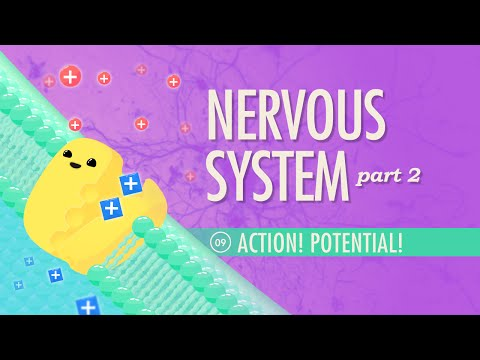

In [6]:
from IPython.display import HTML,YouTubeVideo
YouTubeVideo('OZG8M_ldA1M')